# Modelagem de Machine Learning — Predição de Churn

Este notebook aborda a construção de modelos de Machine Learning
para prever churn de clientes, utilizando pipelines de pré-processamento
e avaliação comparativa entre algoritmos.


In [37]:
#Importando bibliotecas necessárias para manipulação de paths

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


# Pegando o diretório atual
current_dir = os.getcwd()

# Pegando o diretório raiz do projeto
project_root = os.path.dirname(current_dir)

# Adicionando o diretório raiz ao sys.path
sys.path.append(project_root)

# Fazendo a importação do preprocessador
from src.preprocessing import make_preprocessor

## Pré-processamento dos dados

O pré-processamento é realizado por meio de pipelines,
separando variáveis numéricas e categóricas para evitar data leakage
e garantir reprodutibilidade.


In [28]:
#Trazendo o dataset e tratando os dados para modelagem
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df = df.dropna()

X = df.drop('Churn', axis=1)
y = df['Churn']

## Separação dos dados em treino e teste

Os dados são divididos em conjuntos de treino e teste,
preservando a proporção da variável alvo (churn),
para permitir uma avaliação justa dos modelos.


In [29]:
#Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [30]:
#Usando o modulo de pré-processamento
preprocessor = make_preprocessor(X_train)

## Modelo baseline — Regressão Logística

A Regressão Logística é utilizada como modelo baseline,
servindo como referência para comparação com modelos mais complexos.


In [31]:
#Modelo 1: Regressão Logística
log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [32]:
#Treinando o modelo
log_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [33]:
#Avaliando o modelo
y_pred = log_model.predict(X_test)

print(f"Acurácia no Teste: {log_model.score(X_test, y_test):.2%}")
print("-" * 30)
print(classification_report(y_test, y_pred))

Acurácia no Teste: 74.41%
------------------------------
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1033
           1       0.51      0.75      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.74      0.76      1407



## Modelo de maior complexidade — Random Forest

O modelo Random Forest é utilizado para capturar relações
não lineares e interações entre variáveis que modelos lineares
podem não identificar.


In [34]:
#Modelo 2: Random Forest(sem tuning de hiperparâmetros)
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [35]:
#Avaiando o modelo
y_pred_rf = rf_model.predict(X_test)

print(f"Acurácia no Teste (Random Forest): {rf_model.score(X_test, y_test):.2%}")
print("-" * 30)
print(classification_report(y_test, y_pred_rf))

Acurácia no Teste (Random Forest): 78.75%
------------------------------
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



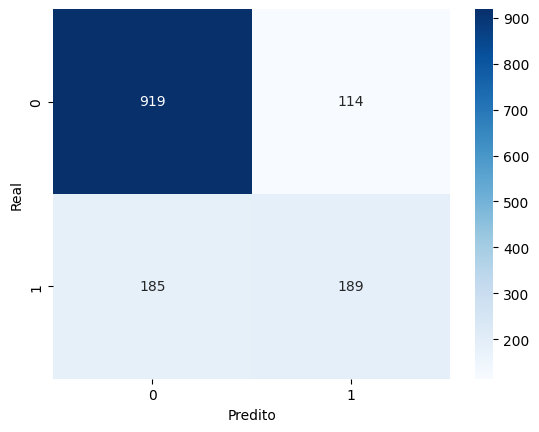

In [36]:
#Matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

## Otimização de hiperparâmetros com GridSearchCV

Após a avaliação inicial do modelo, é realizada a otimização
de hiperparâmetros utilizando GridSearchCV, com foco em recall,
métrica relevante em problemas de churn, onde falsos negativos
representam perda de clientes.


In [50]:
# Executando o Random Forest com tuning de hiperparâmetros usando GridSearchCV:

# Aplicando os hiperparâmetros
param_grid = {
    'classifier__n_estimators': [100, 200,],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 4, 10],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

In [51]:
# Configurando o GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

In [52]:
# Rodando o treinamento
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__class_weight': ['balanced', 'balanced_subsample'], 'classifier__max_depth': [5, 10, ...], 'classifier__min_samples_split': [2, 4, ...], 'classifier__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the

In [53]:
# Resultados do GridSearchCV
print("-" * 30)
print(f"Melhores parâmetros: {grid_search.best_params_}")
print(f"Melhor Recall no Treino: {grid_search.best_score_:.2%}")

------------------------------
Melhores parâmetros: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Melhor Recall no Treino: 82.88%


## Avaliação dos modelos

Os modelos são avaliados utilizando métricas de classificação
e matriz de confusão, permitindo analisar seus acertos e erros
em relação à variável churn.


In [55]:
# Matriz de confusão para o modelo Random Forest tunado:

# Pegando o melhor modelo treinado
best_model = grid_search.best_estimator_

# Prevendo nos dados de teste
y_pred_final = best_model.predict(X_test)

# Relatório de Métricas
print("=== RELATÓRIO FINAL (MODELO OTIMIZADO) ===")
print(classification_report(y_test, y_pred_final))

=== RELATÓRIO FINAL (MODELO OTIMIZADO) ===
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      1033
           1       0.47      0.80      0.59       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.68      1407
weighted avg       0.79      0.71      0.72      1407



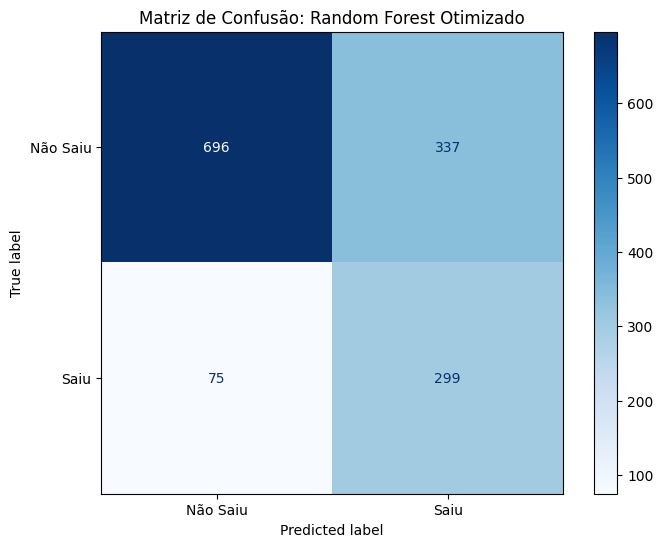

In [56]:
# Matriz de Confusão Visual
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=['Não Saiu', 'Saiu'])

# Plotando a matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Matriz de Confusão: Random Forest Otimizado")
plt.show()

In [57]:
#Usando Feature Importance para interpretar o modelo Random Forest tunado

# Recuperando o melhor modelo e os componentes do pipeline
final_model = grid_search.best_estimator_
preprocessor = final_model.named_steps['preprocessor']
rf_classifier = final_model.named_steps['classifier']

In [58]:
#Recuperando os nomes das features após o pré-processamento
cat_features = X.select_dtypes(include=['object']).columns

C:\Users\Matheus Souza\AppData\Local\Temp\ipykernel_4328\1160462296.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_features = X.select_dtypes(include=['object']).columns


In [59]:
# Extraindo os nomes das colunas numéricas (índice 0)
num_names = preprocessor.transformers_[0][2]
if hasattr(num_names, 'tolist'):
    num_names = num_names.tolist()

In [60]:
#Extraindo os nomes das colunas categóricas (índice 1)
cat_names = preprocessor.transformers_[
    1][1].named_steps['onehot'].get_feature_names_out(cat_features)

In [61]:
#Concatenando os nomes das features
feature_names = list(num_names) + list(cat_names)

In [62]:
#Criando o DataFrame de Importância das Features
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_classifier.feature_importances_
})  

C:\Users\Matheus Souza\AppData\Local\Temp\ipykernel_4328\384121357.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')


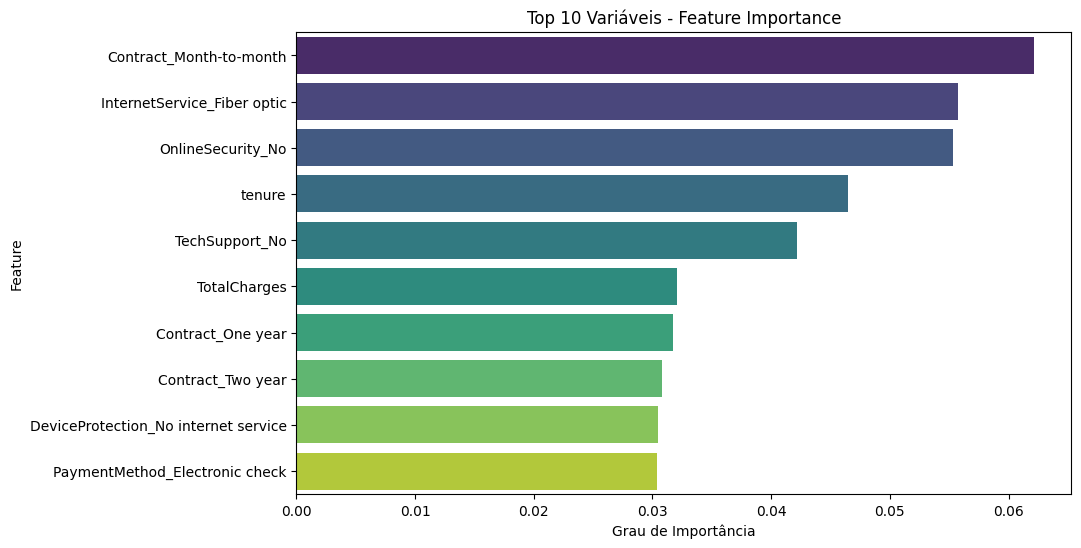

In [64]:
#Ordenando os resultados e gerando o plot
importances = importances.sort_values(
    by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.title('Top 10 Variáveis - Feature Importance')
plt.xlabel('Grau de Importância')
plt.show()

## Conclusão e impacto de negócio

O modelo desenvolvido pode apoiar estratégias de retenção,
permitindo identificar clientes com maior risco de churn e
direcionar ações preventivas, como ofertas personalizadas
ou contato proativo.
